# Is this fire a false alarm? Real-time prediction of fire incident categories in spatio-temporal context

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler

2024-07-04 09:11:10.170303: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 09:11:10.181674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 09:11:10.196605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 09:11:10.196646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 09:11:10.206924: I tensorflow/core/platform/cpu_feature_gua

## Data Preprocessing

In [3]:
# Load the dataset
file_path = 'WMFS_datasets/wmfs_incidents.xlsx'
incidents_df = pd.read_excel(file_path)

In [4]:
# Display the first few rows to understand the structure of the dataset
print(incidents_df.head())
print(incidents_df.info())

            call_time             incident_classification_label  \
0 2009-01-01 00:00:39       False alarm raised with good intent   
1 2009-01-01 00:10:45                            Secondary fire   
2 2009-01-01 00:11:59  False alarm raised with malicious intent   
3 2009-01-01 00:53:02                            Secondary fire   
4 2009-01-01 00:52:13  False alarm raised with malicious intent   

                              incident_profile_label  \
0                                       False Alarms   
1  Secondary Fires that attract a 20 minute-respo...   
2                                       False Alarms   
3  Secondary Fires that attract a 20 minute-respo...   
4                                       False Alarms   

  incident_classification_level1  prl_count  brv_count       EASTINGS  \
0                    FALSE_ALARM          2          0  392062.102010   
1                           FIRE          1          0  405643.149442   
2                    FALSE_ALARM         

In [5]:
# Extract relevant columns
relevant_columns = [
    'call_time', 
    'incident_classification_level1', 
    'EASTINGS', 
    'NORTHINGS'
]

# Create a new DataFrame with only the relevant columns
incidents_df = incidents_df[relevant_columns]

# Display the first few rows of the extracted DataFrame
print(incidents_df.head())

            call_time incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                    FALSE_ALARM  392062.102010   
1 2009-01-01 00:10:45                           FIRE  405643.149442   
2 2009-01-01 00:11:59                    FALSE_ALARM  410260.244387   
3 2009-01-01 00:53:02                           FIRE  396779.250331   
4 2009-01-01 00:52:13                    FALSE_ALARM  410667.961350   

       NORTHINGS  
0  286844.969007  
1  277939.980158  
2  288819.189377  
3  299030.106069  
4  290492.478579  


In [6]:
# Filter to keep only FIRE and FALSE_ALARM incidents
incidents_df = incidents_df[incidents_df['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]

# Display the filtered DataFrame
print(incidents_df.head())

            call_time incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                    FALSE_ALARM  392062.102010   
1 2009-01-01 00:10:45                           FIRE  405643.149442   
2 2009-01-01 00:11:59                    FALSE_ALARM  410260.244387   
3 2009-01-01 00:53:02                           FIRE  396779.250331   
4 2009-01-01 00:52:13                    FALSE_ALARM  410667.961350   

       NORTHINGS  
0  286844.969007  
1  277939.980158  
2  288819.189377  
3  299030.106069  
4  290492.478579  


## Feature Engineering

In [7]:
# Define peak and off-peak hours
def classify_peak_hours(hour):
    if (7 <= hour < 9) or (16 <= hour < 18):
        return 'Peak'
    else:
        return 'Off-Peak'

# Apply peak/off-peak classification
incidents_df['peak_hour'] = incidents_df['call_time'].dt.hour.apply(classify_peak_hours)

# Define weekdays and weekends
def classify_day_of_week(day):
    if day < 5:  # 0-4 are Monday to Friday
        return 'Weekday'
    else:
        return 'Weekend'

# Apply weekday/weekend classification
incidents_df['day_type'] = incidents_df['call_time'].dt.dayofweek.apply(classify_day_of_week)

# Define seasons
def classify_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply season classification
incidents_df['season'] = incidents_df['call_time'].dt.month.apply(classify_season)

# Display the DataFrame with new temporal features
print(incidents_df.head())

            call_time incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                    FALSE_ALARM  392062.102010   
1 2009-01-01 00:10:45                           FIRE  405643.149442   
2 2009-01-01 00:11:59                    FALSE_ALARM  410260.244387   
3 2009-01-01 00:53:02                           FIRE  396779.250331   
4 2009-01-01 00:52:13                    FALSE_ALARM  410667.961350   

       NORTHINGS peak_hour day_type  season  
0  286844.969007  Off-Peak  Weekday  Winter  
1  277939.980158  Off-Peak  Weekday  Winter  
2  288819.189377  Off-Peak  Weekday  Winter  
3  299030.106069  Off-Peak  Weekday  Winter  
4  290492.478579  Off-Peak  Weekday  Winter  


In [8]:
# Check unique values for each new temporal feature
print("Unique values for 'peak_hour':", incidents_df['peak_hour'].unique())
print("Unique values for 'day_type':", incidents_df['day_type'].unique())
print("Unique values for 'season':", incidents_df['season'].unique())

Unique values for 'peak_hour': ['Off-Peak' 'Peak']
Unique values for 'day_type': ['Weekday' 'Weekend']
Unique values for 'season': ['Winter' 'Spring' 'Summer' 'Autumn']


In [9]:
# Get value counts for each new temporal feature
print("Value counts for 'peak_hour':\n", incidents_df['peak_hour'].value_counts())
print("Value counts for 'day_type':\n", incidents_df['day_type'].value_counts())
print("Value counts for 'season':\n", incidents_df['season'].value_counts())

Value counts for 'peak_hour':
 peak_hour
Off-Peak    240502
Peak         52195
Name: count, dtype: int64
Value counts for 'day_type':
 day_type
Weekday    203285
Weekend     89412
Name: count, dtype: int64
Value counts for 'season':
 season
Summer    86706
Spring    77607
Autumn    72185
Winter    56199
Name: count, dtype: int64


In [10]:
# Digimap
# Extract bounding box from data
min_easting = incidents_df['EASTINGS'].min()
max_easting = incidents_df['EASTINGS'].max()
min_northing = incidents_df['NORTHINGS'].min()
max_northing = incidents_df['NORTHINGS'].max()

print(f"Bounding Box: ({min_easting}, {min_northing}) to ({max_easting}, {max_northing})")

Bounding Box: (386159.37650158, 272135.394576111) to (439375.357953017, 307318.670460413)


In [11]:
# Overpass Turbo query

# Define the transformer
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326")

# Convert coordinates
min_easting, min_northing = 386159.37650158, 272135.394576111
max_easting, max_northing = 439375.357953017, 307318.670460413

min_lat, min_lon = transformer.transform(min_easting, min_northing)
max_lat, max_lon = transformer.transform(max_easting, max_northing)

print(f"Bounding Box in Lat/Lon: ({min_lat}, {min_lon}) to ({max_lat}, {max_lon})")

Bounding Box in Lat/Lon: (52.34711291078041, -2.2046027179251584) to (52.66216380940898, -1.4192589477566762)


In [12]:
# Overpass Turbo query
query = f"""
[out:json];
(
  node["amenity"="residential"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="restaurant"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="bar"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="cafe"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="pub"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="school"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="university"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="hospital"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="clinic"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="residential"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="restaurant"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="bar"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="cafe"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="pub"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="school"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="university"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="hospital"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="clinic"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="residential"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="restaurant"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="bar"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="cafe"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="pub"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="school"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="university"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="hospital"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="clinic"]({min_lat},{min_lon},{max_lat},{max_lon});
);
out center;
"""

print(query)


[out:json];
(
  node["amenity"="residential"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="restaurant"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="bar"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="cafe"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="pub"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="school"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="university"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="hospital"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="clinic"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  way["amenity"="residential"](52

In [13]:
# Label encode the 'incident_classification_level1' column
label_encoder = LabelEncoder()
incidents_df['incident_classification_level1_encoded'] = label_encoder.fit_transform(incidents_df['incident_classification_level1'])

# Display the first few rows to see the new encoded column
print(incidents_df.head())

# Check the unique values in the encoded column to ensure it worked correctly
print(incidents_df['incident_classification_level1_encoded'].unique())
print(label_encoder.classes_)

            call_time incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                    FALSE_ALARM  392062.102010   
1 2009-01-01 00:10:45                           FIRE  405643.149442   
2 2009-01-01 00:11:59                    FALSE_ALARM  410260.244387   
3 2009-01-01 00:53:02                           FIRE  396779.250331   
4 2009-01-01 00:52:13                    FALSE_ALARM  410667.961350   

       NORTHINGS peak_hour day_type  season  \
0  286844.969007  Off-Peak  Weekday  Winter   
1  277939.980158  Off-Peak  Weekday  Winter   
2  288819.189377  Off-Peak  Weekday  Winter   
3  299030.106069  Off-Peak  Weekday  Winter   
4  290492.478579  Off-Peak  Weekday  Winter   

   incident_classification_level1_encoded  
0                                       0  
1                                       1  
2                                       0  
3                                       1  
4                                       0  
[0 1]
['FALSE_ALARM' 'FIRE

In [14]:
# Convert incident data to GeoDataFrame with original CRS (EPSG:27700)
incidents_gdf = gpd.GeoDataFrame(incidents_df, geometry=gpd.points_from_xy(incidents_df.EASTINGS, incidents_df.NORTHINGS), crs="EPSG:27700")

# Transform the CRS of incidents to EPSG:4326 (WGS84)
incidents_gdf = incidents_gdf.to_crs(epsg=4326)

# Convert the CRS to a projected CRS (EPSG:3857) for accurate buffering
incidents_gdf = incidents_gdf.to_crs(epsg=3857)

# Load POI data (assuming GeoJSON format)
poi_data = gpd.read_file("export.geojson")

# Ensure POI data CRS is EPSG:4326, then convert to EPSG:3857 for accurate spatial join
if poi_data.crs != "EPSG:4326":
    poi_data = poi_data.to_crs(epsg=4326)
poi_data = poi_data.to_crs(epsg=3857)

# Check the extent of the POI data
print("POI Data Bounding Box:", poi_data.total_bounds)

# Buffer incidents to find nearby POIs (e.g., within 500 meters)
buffer_distance = 500  # 500 meters in projected CRS

incidents_gdf['buffer'] = incidents_gdf.geometry.buffer(buffer_distance)
incidents_gdf = incidents_gdf.set_geometry('buffer')

POI Data Bounding Box: [-278288.45219418 6863152.55292415 -158076.19274694 7055423.9616344 ]


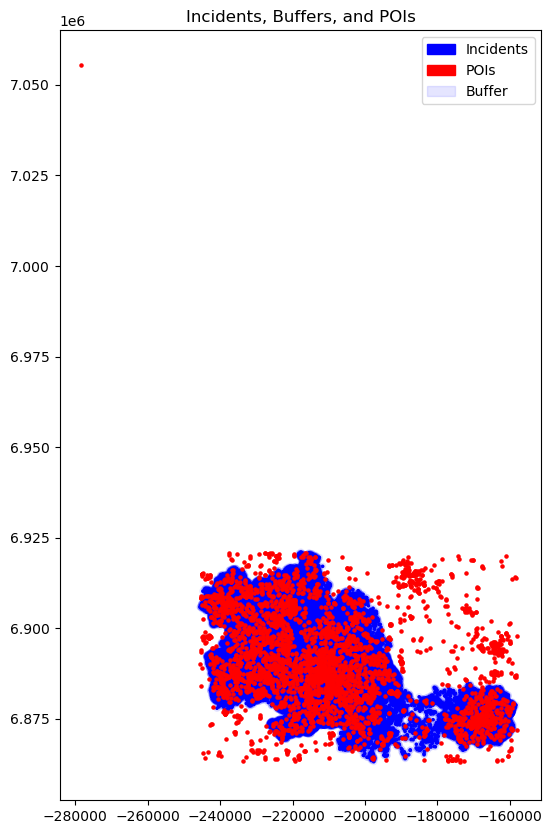

In [15]:
# Plot the incident locations with buffers and POIs
fig, ax = plt.subplots(figsize=(10, 10))

incidents_gdf.plot(ax=ax, color='blue', markersize=5, label='Incidents')
incidents_gdf.buffer(buffer_distance).plot(ax=ax, color='blue', alpha=0.1, label='Buffer')
poi_data.plot(ax=ax, color='red', markersize=5, label='POIs')

# Create custom legend handles
incidents_patch = mpatches.Patch(color='blue', label='Incidents')
pois_patch = mpatches.Patch(color='red', label='POIs')
buffer_patch = mpatches.Patch(color='blue', alpha=0.1, label='Buffer')

plt.legend(handles=[incidents_patch, pois_patch, buffer_patch])
plt.title('Incidents, Buffers, and POIs')
plt.show()

In [16]:
# Process data in batches
batch_size = 1000  # Adjust batch size as needed
incidents_df['poi_count'] = 0  # Initialize POI count column

for start in range(0, len(incidents_df), batch_size):
    end = min(start + batch_size, len(incidents_df))
    batch_incidents = incidents_df.iloc[start:end]
    batch_gdf = gpd.GeoDataFrame(batch_incidents, geometry=gpd.points_from_xy(batch_incidents.EASTINGS, batch_incidents.NORTHINGS), crs="EPSG:27700")
    batch_gdf = batch_gdf.to_crs(epsg=4326)
    batch_gdf = batch_gdf.to_crs(epsg=3857)
    batch_gdf['buffer'] = batch_gdf.geometry.buffer(buffer_distance)
    batch_gdf = batch_gdf.set_geometry('buffer')

    # Perform spatial join to find POIs within the buffer
    joined_gdf = gpd.sjoin(poi_data, batch_gdf[['buffer']], how="inner", predicate="within")

    # Count POIs within the buffer for each incident
    poi_counts = joined_gdf.groupby('index_right').size()
    incidents_df.loc[batch_incidents.index, 'poi_count'] = batch_incidents.index.map(poi_counts).fillna(0)

# Display the updated incidents DataFrame
print(incidents_df.head())

            call_time incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                    FALSE_ALARM  392062.102010   
1 2009-01-01 00:10:45                           FIRE  405643.149442   
2 2009-01-01 00:11:59                    FALSE_ALARM  410260.244387   
3 2009-01-01 00:53:02                           FIRE  396779.250331   
4 2009-01-01 00:52:13                    FALSE_ALARM  410667.961350   

       NORTHINGS peak_hour day_type  season  \
0  286844.969007  Off-Peak  Weekday  Winter   
1  277939.980158  Off-Peak  Weekday  Winter   
2  288819.189377  Off-Peak  Weekday  Winter   
3  299030.106069  Off-Peak  Weekday  Winter   
4  290492.478579  Off-Peak  Weekday  Winter   

   incident_classification_level1_encoded  poi_count  
0                                       0          9  
1                                       1          0  
2                                       0          1  
3                                       1          1  
4              

In [17]:
print(incidents_gdf.crs)
print(poi_data.crs)

EPSG:3857
EPSG:3857


## Exploratory Data Analysis (EDA)

In [18]:
# Check the dataframe info
print(incidents_df.info())

# Check for missing values
print(incidents_df.isnull().sum())

# Display basic statistics
print(incidents_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 292697 entries, 0 to 383667
Data columns (total 9 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   call_time                               292697 non-null  datetime64[ns]
 1   incident_classification_level1          292697 non-null  object        
 2   EASTINGS                                292697 non-null  float64       
 3   NORTHINGS                               292697 non-null  float64       
 4   peak_hour                               292697 non-null  object        
 5   day_type                                292697 non-null  object        
 6   season                                  292697 non-null  object        
 7   incident_classification_level1_encoded  292697 non-null  int64         
 8   poi_count                               292697 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2),

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


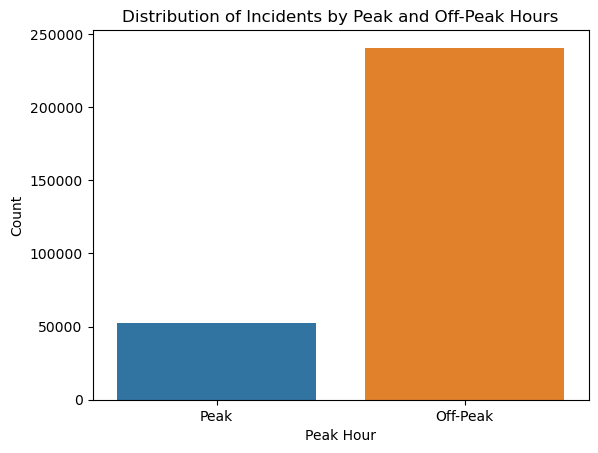

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


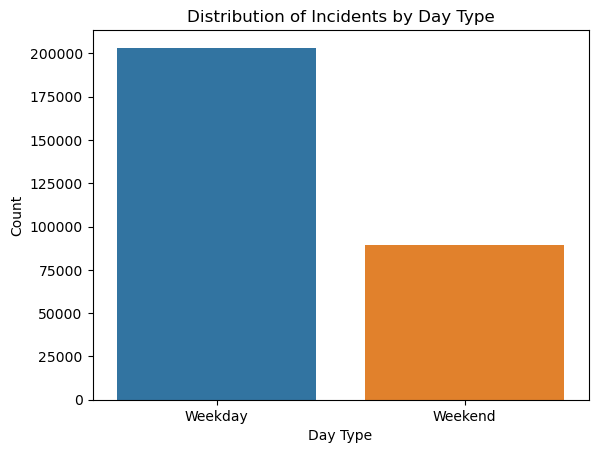

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


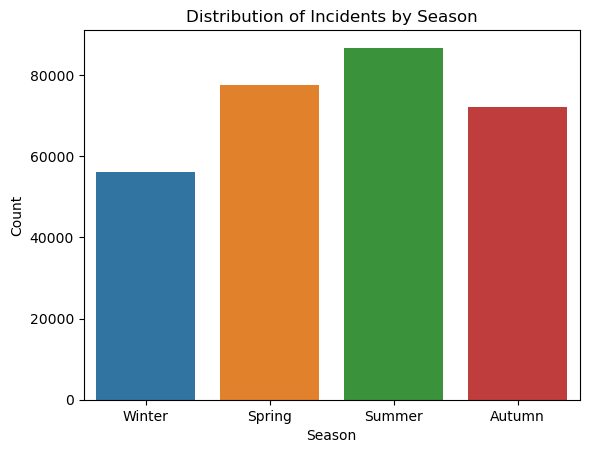

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


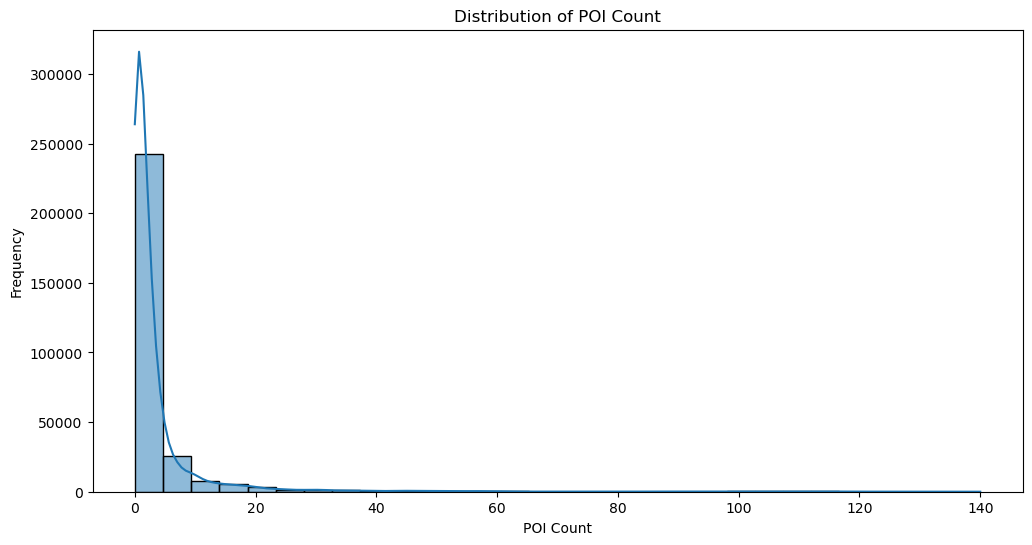

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

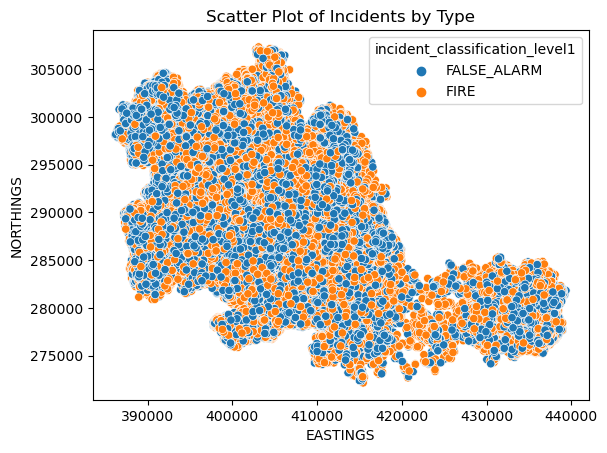

In [19]:
# Distribution of incidents by peak and off-peak hours
sns.countplot(data=incidents_df, x='peak_hour', order=['Peak', 'Off-Peak'])
plt.title('Distribution of Incidents by Peak and Off-Peak Hours')
plt.xlabel('Peak Hour')
plt.ylabel('Count')
plt.show()

# Distribution of incidents by day type (Weekday/Weekend)
sns.countplot(data=incidents_df, x='day_type', order=['Weekday', 'Weekend'])
plt.title('Distribution of Incidents by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Count')
plt.show()

# Distribution of incidents by season
sns.countplot(data=incidents_df, x='season', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Distribution of Incidents by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

# Distribution of poi_count
plt.figure(figsize=(12, 6))
sns.histplot(incidents_df['poi_count'], bins=30, kde=True)
plt.title('Distribution of POI Count')
plt.xlabel('POI Count')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of incidents
sns.scatterplot(x='EASTINGS', y='NORTHINGS', hue='incident_classification_level1', data=incidents_df)
plt.title('Scatter Plot of Incidents by Type')
plt.show()


## Model Training and Evaluation

In [20]:
# Define features and target variable
features = ['peak_hour', 'day_type', 'season', 'poi_count']

# One-hot encode the categorical features
X = pd.get_dummies(incidents_df[features], drop_first=True)

# Convert all features to float type
X = X.astype(np.float32)

# Target variable
y = incidents_df['incident_classification_level1_encoded']

# Display the first few rows of the features and target
print(X.head())
print(y.head())


   poi_count  peak_hour_Peak  day_type_Weekend  season_Spring  season_Summer  \
0        9.0             0.0               0.0            0.0            0.0   
1        0.0             0.0               0.0            0.0            0.0   
2        1.0             0.0               0.0            0.0            0.0   
3        1.0             0.0               0.0            0.0            0.0   
4        1.0             0.0               0.0            0.0            0.0   

   season_Winter  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0  
0    0
1    1
2    0
3    1
4    0
Name: incident_classification_level1_encoded, dtype: int64


In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Create a function to evaluate the models using the specified metrics
def evaluate_model(y_test, y_pred, y_prob):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))

In [23]:
# Train a Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# Predict and evaluate
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_probabilities = log_reg_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, log_reg_predictions, log_reg_probabilities)

Confusion Matrix:
[[20241 21811]
 [16650 29108]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51     42052
           1       0.57      0.64      0.60     45758

    accuracy                           0.56     87810
   macro avg       0.56      0.56      0.56     87810
weighted avg       0.56      0.56      0.56     87810

Precision: 0.5716530175376578
Recall: 0.6361292014511124
F1 Score: 0.6021701128500058
AUC-ROC: 0.5870420159860107


In [24]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, rf_predictions, rf_probabilities)

Confusion Matrix:
[[18097 23955]
 [13583 32175]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.43      0.49     42052
           1       0.57      0.70      0.63     45758

    accuracy                           0.57     87810
   macro avg       0.57      0.57      0.56     87810
weighted avg       0.57      0.57      0.56     87810

Precision: 0.5732228754676644
Recall: 0.7031557323309585
F1 Score: 0.6315758479899498
AUC-ROC: 0.5972259597051269


In [25]:
# Train an XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_predictions = xgb_model.predict(X_test)
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, xgb_predictions, xgb_probabilities)

Confusion Matrix:
[[18602 23450]
 [13928 31830]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.44      0.50     42052
           1       0.58      0.70      0.63     45758

    accuracy                           0.57     87810
   macro avg       0.57      0.57      0.56     87810
weighted avg       0.57      0.57      0.57     87810

Precision: 0.5757959479015919
Recall: 0.6956160671358014
F1 Score: 0.6300599774342327
AUC-ROC: 0.5996035620057625


In [26]:
# Define the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Predict and evaluate
nn_probabilities = nn_model.predict(X_test).ravel()
nn_predictions = (nn_probabilities > 0.5).astype(int)
evaluate_model(y_test, nn_predictions, nn_probabilities)

Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20489/20489 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.5659 - loss: 0.6809 - val_accuracy: 0.5734 - val_loss: 0.6775
Epoch 2/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.5702 - loss: 0.6785 - val_accuracy: 0.5721 - val_loss: 0.6773
Epoch 3/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.5714 - loss: 0.6782 - val_accuracy: 0.5735 - val_loss: 0.6775
Epoch 4/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.5709 - loss: 0.6782 - val_accuracy: 0.5728 - val_loss: 0.6773
Epoch 5/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.5727 - loss: 0.6778 - val_accuracy: 0.5736 - val_loss: 0.6771
Epoch 6/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.5728 - loss: 0.6778 - val_accuracy: 0.5736 - val_loss: 0.6771
Epoch 7/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.5729 - loss: 0.6774 - val_accuracy: 0.5754 - val_loss: 0.6768
Epoch 8/50
20489/20489 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.5721 - lo